<a href="https://colab.research.google.com/github/xinyuezhang-shirley/cs229FinalProject/blob/main/CS229_ProjectionLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64   #  CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE
EPOCHS = 100 #  CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE
LR = 1e-3
ALPHA = 0.3     # weight for contrastive loss  CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE
BETA = 0.5   # you can try 0.1, 0.5, 1.0      CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE



In [ ]:
# MPNet embeddings
poem_vecs = np.load("data/processed/mpnet_embeddings_poems.npy")
song_vecs = np.load("data/processed/mpnet_embeddings_songs.npy")

# Extra numeric features
feats = np.load("data/processed/additional_features.npz")
poem_feats = feats["poems_standardized"]
song_feats = feats["songs_standardized"]

# Align song embeddings if needed
idx_map = feats["songs_source_indexes"]
song_vecs = song_vecs[idx_map]       # reorder + shrink
song_feats = song_feats              # already aligned

print(poem_vecs.shape, song_vecs.shape)
print(poem_feats.shape, song_feats.shape)


(3413, 768) (2934, 768)
(3413, 3) (2934, 4)


In [ ]:
poems_norm = poem_vecs / np.linalg.norm(poem_vecs, axis=1, keepdims=True)
songs_norm = song_vecs / np.linalg.norm(song_vecs, axis=1, keepdims=True)

cos_matrix = poems_norm @ songs_norm.T
cos_vals = cos_matrix.ravel()

print("cosine min =", float(cos_vals.min()))
print("cosine max =", float(cos_vals.max()))


cosine min = -0.23297259211540222
cosine max = 0.8309503197669983


In [ ]:
neg_thresh  = np.percentile(cos_vals, 20)
hard_low    = np.percentile(cos_vals, 40)
hard_high   = np.percentile(cos_vals, 70)
pos_thresh  = np.percentile(cos_vals, 90)

print("neg:", neg_thresh)
print("hard:", hard_low, hard_high)
print("pos:", pos_thresh)

pos_pairs  = np.argwhere(cos_matrix >= pos_thresh)
neg_pairs  = np.argwhere(cos_matrix <= neg_thresh)
hard_pairs = np.argwhere((cos_matrix >= hard_low) & (cos_matrix <= hard_high))

print(len(pos_pairs), len(neg_pairs), len(hard_pairs))


neg: 0.25191563
hard: 0.32118356 0.4132118
pos: 0.49966234
1001376 2002749 3004122


In [ ]:
poem_in = np.concatenate([poem_vecs, poem_feats], axis=1)   # (3413, 768+3)
song_in = np.concatenate([song_vecs, song_feats], axis=1)   # (2934, 768+4)

print("poem_in:", poem_in.shape)
print("song_in:", song_in.shape)


poem_in: (3413, 771)
song_in: (2934, 772)


In [ ]:
class PairDataset(Dataset):
    def __init__(self, pos_pairs, neg_pairs, hard_pairs, poem_in, song_in, cos_matrix, size=50000):
        """
        size = number of samples per epoch
        We randomly draw positives every epoch.
        """
        self.pos_pairs  = pos_pairs
        self.neg_pairs  = neg_pairs
        self.hard_pairs = hard_pairs
        self.poem_in    = poem_in
        self.song_in    = song_in
        self.cos_matrix = cos_matrix
        self.size = size  # dataset length per epoch

    def __len__(self):
        # defines how many samples per epoch
        return self.size

    def __getitem__(self, idx):
        # sample a random positive every time
        i, j_pos = self.pos_pairs[np.random.randint(len(self.pos_pairs))]
        target = self.cos_matrix[i, j_pos]

        # negative: 50% hard, 50% easy
        if np.random.rand() < 0.5 and len(self.hard_pairs) > 0:
            i_neg, j_neg = self.hard_pairs[np.random.randint(len(self.hard_pairs))]
        else:
            i_neg, j_neg = self.neg_pairs[np.random.randint(len(self.neg_pairs))]

        p     = self.poem_in[i]
        s_pos = self.song_in[j_pos]
        s_neg = self.song_in[j_neg]

        return (
            torch.tensor(p,     dtype=torch.float32),
            torch.tensor(s_pos, dtype=torch.float32),
            torch.tensor(s_neg, dtype=torch.float32),
            torch.tensor(target, dtype=torch.float32),
        )


In [ ]:
dataset = PairDataset(
    pos_pairs,
    neg_pairs,
    hard_pairs,
    poem_in,
    song_in,
    cos_matrix,
    size=10000   # number of training samples per epoch  CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE
)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,       # faster on Mac
    pin_memory=True     # faster on CPU
)


In [ ]:
p_dim = poem_in.shape[1]
s_dim = song_in.shape[1]
proj_dim = 128

class ProjectionModel(nn.Module):
    def __init__(self, p_dim, s_dim, proj_dim):
        super().__init__()
        self.poem_proj = nn.Sequential(
            nn.Linear(p_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim)
        )
        self.song_proj = nn.Sequential(
            nn.Linear(s_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, p, s):
        p_z = self.poem_proj(p)
        s_z = self.song_proj(s)

        # normalize for cosine
        p_norm = p_z / (p_z.norm(dim=1, keepdim=True) + 1e-8)
        s_norm = s_z / (s_z.norm(dim=1, keepdim=True) + 1e-8)

        cos_sim = (p_norm * s_norm).sum(dim=1)
        return cos_sim


In [ ]:
def clip_loss(p_z, s_z, temperature=0.1):
    # Normalize embeddings
    p = F.normalize(p_z, dim=1)
    s = F.normalize(s_z, dim=1)

    # Cosine similarity matrix (B, B)
    logits = (p @ s.T) / temperature
    labels = torch.arange(logits.shape[0], device=logits.device)

    # poem → song and song → poem
    loss_p_to_s = F.cross_entropy(logits, labels)
    loss_s_to_p = F.cross_entropy(logits.T, labels)

    return (loss_p_to_s + loss_s_to_p) / 2


In [ ]:
model = ProjectionModel(p_dim, s_dim, proj_dim).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:

loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total = 0.0

    for p, s_pos, s_neg, target in loader:
        p     = p.to(DEVICE)
        s_pos = s_pos.to(DEVICE)

        # 1. embed poems and songs
        p_z = model.poem_proj(p)      # (B, d)
        s_z = model.song_proj(s_pos)  # (B, d)

        # 2. symmetric contrastive loss (InfoNCE-style)
        contrast = clip_loss(p_z, s_z)

        # 3. pairwise alignment loss: make each poem close to its song
        align = F.mse_loss(p_z, s_z)

        # 4. total loss
        loss = contrast + BETA * align

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()

    avg = total / len(loader)
    loss_history.append(avg)
    print(f"epoch {epoch+1}/{EPOCHS}  loss={avg:.4f}")


epoch 1/100  loss=3.9982
epoch 2/100  loss=3.9022
epoch 3/100  loss=3.8624
epoch 4/100  loss=3.8339
epoch 5/100  loss=3.8252
epoch 6/100  loss=3.8225
epoch 7/100  loss=3.8342
epoch 8/100  loss=3.8104
epoch 9/100  loss=3.8078
epoch 10/100  loss=3.8088
epoch 11/100  loss=3.7895
epoch 12/100  loss=3.8024
epoch 13/100  loss=3.7954
epoch 14/100  loss=3.8012
epoch 15/100  loss=3.7906
epoch 16/100  loss=3.7916
epoch 17/100  loss=3.7955
epoch 18/100  loss=3.7957
epoch 19/100  loss=3.7916
epoch 20/100  loss=3.7741
epoch 21/100  loss=3.7856
epoch 22/100  loss=3.7791
epoch 23/100  loss=3.7749
epoch 24/100  loss=3.7773
epoch 25/100  loss=3.7690
epoch 26/100  loss=3.7701
epoch 27/100  loss=3.7697
epoch 28/100  loss=3.7614
epoch 29/100  loss=3.7725
epoch 30/100  loss=3.7680
epoch 31/100  loss=3.7642
epoch 32/100  loss=3.7773
epoch 33/100  loss=3.7645
epoch 34/100  loss=3.7635
epoch 35/100  loss=3.7484
epoch 36/100  loss=3.7564
epoch 37/100  loss=3.7562
epoch 38/100  loss=3.7589
epoch 39/100  loss=3.

In [ ]:
torch.save(model.state_dict(), "reward_model.pt")
print("Model saved.")


Model saved.


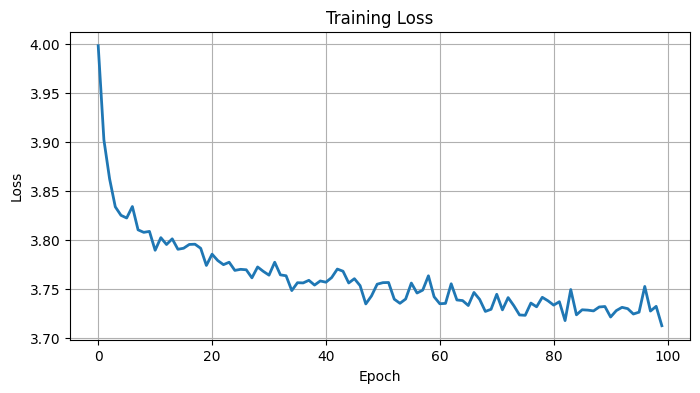

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(loss_history, linewidth=2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


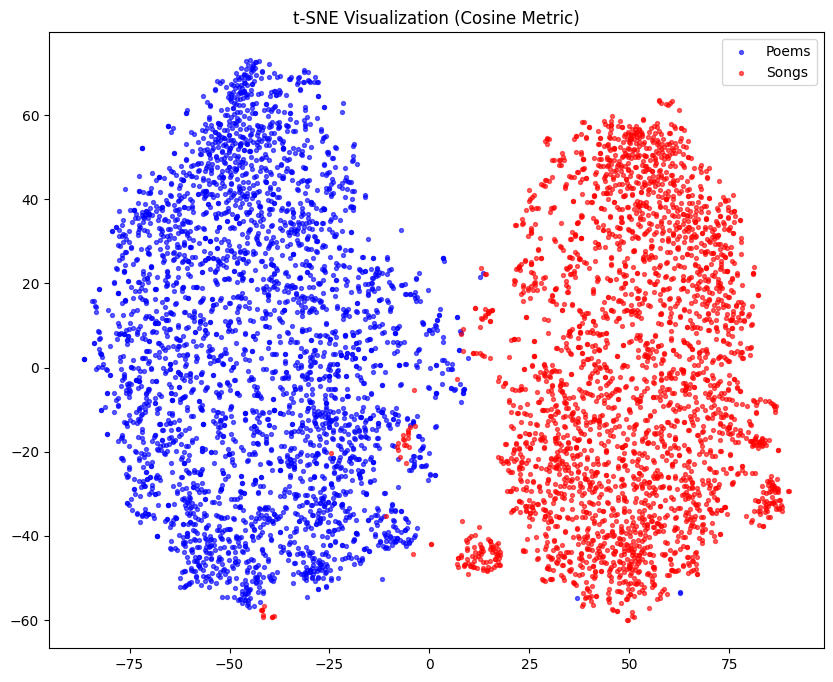

In [ ]:
from sklearn.manifold import TSNE

# Get embedded vectors (not cosine scores!)
model.eval()
with torch.no_grad():
    poems_emb = model.poem_proj(torch.tensor(poem_in, dtype=torch.float32).to(DEVICE))
    songs_emb = model.song_proj(torch.tensor(song_in, dtype=torch.float32).to(DEVICE))

# Normalize for cosine-based geometry
poems_emb = poems_emb / (poems_emb.norm(dim=1, keepdim=True) + 1e-8)
songs_emb = songs_emb / (songs_emb.norm(dim=1, keepdim=True) + 1e-8)

# Convert to CPU numpy
poems_emb = poems_emb.cpu().numpy()
songs_emb = songs_emb.cpu().numpy()

# Stack for t-SNE
combined = np.vstack([poems_emb, songs_emb])

# TSNE with cosine distance
tsne = TSNE(n_components=2, metric="cosine", perplexity=30, n_iter=2000)
coords = tsne.fit_transform(combined)

N_poems = poems_emb.shape[0]
poem_xy = coords[:N_poems]
song_xy = coords[N_poems:]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(poem_xy[:,0], poem_xy[:,1], s=8, c='blue', alpha=0.6, label='Poems')
plt.scatter(song_xy[:,0], song_xy[:,1], s=8, c='red', alpha=0.6, label='Songs')
plt.legend()
plt.title("t-SNE Visualization (Cosine Metric)")
plt.show()


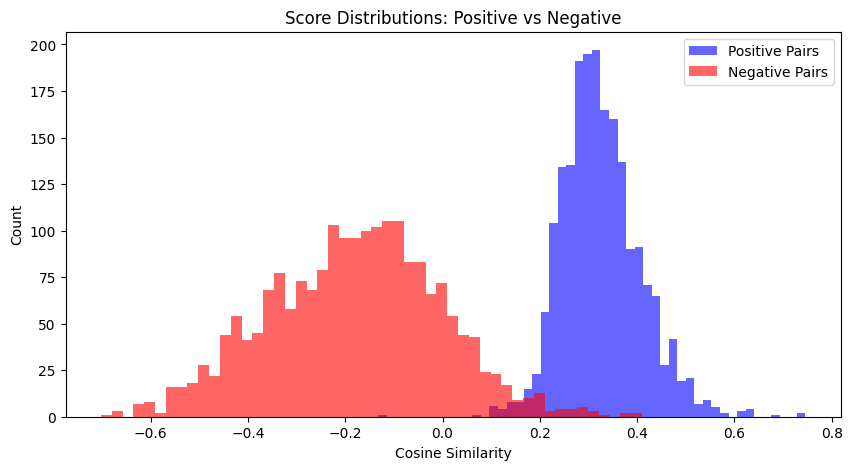

In [ ]:
model.eval()

pos_scores_list = []
neg_scores_list = []

with torch.no_grad():
    for i,j in pos_pairs[:2000]:        # sample subset for speed
        p = poem_in[i]
        s = song_in[j]
        score = model(
            torch.tensor(p, dtype=torch.float32).unsqueeze(0).to(DEVICE),
            torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        )
        pos_scores_list.append(float(score))

    for i,j in neg_pairs[:2000]:
        p = poem_in[i]
        s = song_in[j]
        score = model(
            torch.tensor(p, dtype=torch.float32).unsqueeze(0).to(DEVICE),
            torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        )
        neg_scores_list.append(float(score))

plt.figure(figsize=(10,5))
plt.hist(pos_scores_list, bins=50, alpha=0.6, label='Positive Pairs', color='blue')
plt.hist(neg_scores_list, bins=50, alpha=0.6, label='Negative Pairs', color='red')
plt.legend()
plt.title("Score Distributions: Positive vs Negative")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

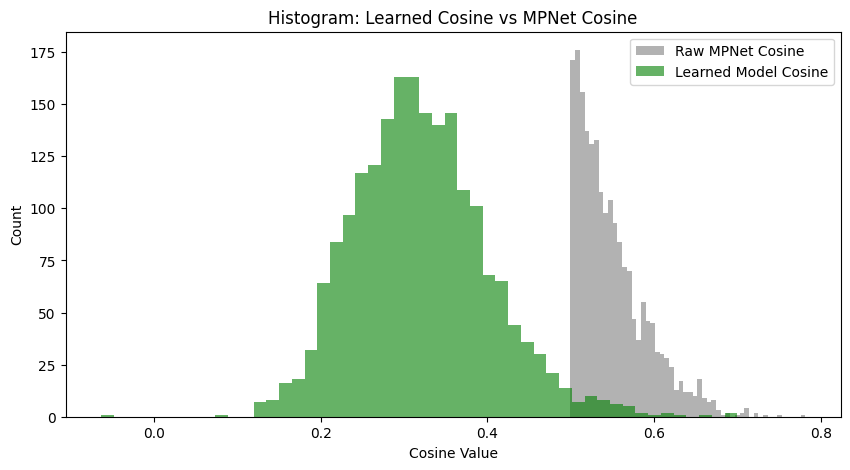

In [ ]:
# sample some positives
sampled = pos_pairs[np.random.choice(len(pos_pairs), size=2000, replace=False)]

raw = []
learned = []

model.eval()
with torch.no_grad():
    for i,j in sampled:
        raw.append(cos_matrix[i,j])

        p = poem_in[i]
        s = song_in[j]
        pred = model(
            torch.tensor(p, dtype=torch.float32).unsqueeze(0).to(DEVICE),
            torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        )
        learned.append(float(pred))

plt.figure(figsize=(10,5))
plt.hist(raw, bins=50, alpha=0.6, label="Raw MPNet Cosine", color='gray')
plt.hist(learned, bins=50, alpha=0.6, label="Learned Model Cosine", color='green')
plt.legend()
plt.title("Histogram: Learned Cosine vs MPNet Cosine")
plt.xlabel("Cosine Value")
plt.ylabel("Count")
plt.show()

In [209]:
import json
import numpy as np
import torch
import torch.nn.functional as F

# --------------------------------------------
# 1. Load poem and song titles
# --------------------------------------------

# Poems
with open("data/raw/poetrydb_poems.json", "r") as f:
    poem_data = json.load(f)

poem_titles = [p.get("title", "Untitled Poem") for p in poem_data["items"]]
print("Loaded", len(poem_titles), "poems")

# Songs
with open("data/processed/combined_songs_large_fixed.json", "r") as f:
    song_data = json.load(f)

song_titles  = [s.get("title", "Untitled Song") for s in song_data["items"]]
song_artists = [s.get("artist", "Unknown Artist") for s in song_data["items"]]

print("Loaded", len(song_titles), "songs")


# --------------------------------------------
# 2. Compute learned similarities
# --------------------------------------------

model.eval()
with torch.no_grad():
    p_vecs = model.poem_proj(torch.tensor(poem_in, dtype=torch.float32).to(DEVICE))
    s_vecs = model.song_proj(torch.tensor(song_in, dtype=torch.float32).to(DEVICE))

    p_vecs = F.normalize(p_vecs, dim=1)
    s_vecs = F.normalize(s_vecs, dim=1)

sim_learned = (p_vecs @ s_vecs.T).cpu().numpy()


# --------------------------------------------
# 3. Pick a random poem and show top matches
# --------------------------------------------

i = np.random.randint(len(poem_titles))

print("=" * 80)
print("Random poem #{}: {}".format(i, poem_titles[i]))
print("=" * 80)
print()

# MPNet baseline
top_mpnet = cos_matrix[i].argsort()[::-1][:10]
print("Top-10 MPNet songs:")
for rank, j in enumerate(top_mpnet, 1):
    print("{:2d}. cos={:.4f} | {} — {}".format(rank, cos_matrix[i, j], song_titles[j], song_artists[j]))
print()

# Learned model
top_learned = sim_learned[i].argsort()[::-1][:10]
print("Top-10 learned-model songs:")
for rank, j in enumerate(top_learned, 1):
    print("{:2d}. sim={:.4f} | {} — {}".format(rank, sim_learned[i, j], song_titles[j], song_artists[j]))
print()

# Overlap
overlap = sorted(set(top_mpnet) & set(top_learned))
print("Overlap count:", len(overlap))
print("Overlapping indices:", overlap)
print()

# Score summary
print("MPNet avg top-10 cosine:", np.mean([cos_matrix[i, j] for j in top_mpnet]))
print("Model avg top-10 sim:", np.mean([sim_learned[i, j] for j in top_learned]))
print("=" * 80)


Loaded 3413 poems
Loaded 3000 songs
Random poem #499: Faith and Despondency

Top-10 MPNet songs:
 1. cos=0.6955 | Starboy — The Weeknd
 2. cos=0.6853 | A Little More — Ed Sheeran
 3. cos=0.6727 | You And Whose Army? — Radiohead
 4. cos=0.6610 | Demi Moore — Phoebe Bridgers
 5. cos=0.6563 | UGLY - 2014 WORLD TOUR 〜ALL OR NOTHING〜 in JAPAN Ver. — 2NE1
 6. cos=0.6536 | I Bet You Look Good On The Dancefloor - Live — Arctic Monkeys
 7. cos=0.6505 | Opening Night — The Weeknd
 8. cos=0.6490 | I Always Wanna Die (Sometimes) (Live From The AO Arena, Manchester, 17.02.24) — The 1975
 9. cos=0.6385 | Gramercy Park — Alicia Keys
10. cos=0.6349 | Atlantic City — Bruce Springsteen

Top-10 learned-model songs:
 1. sim=0.5370 | Queen of the Sea — Norah Jones
 2. sim=0.5242 | I Bet You Look Good On The Dancefloor - Live — Arctic Monkeys
 3. sim=0.5171 | I Always Wanna Die (Sometimes) (Live From The AO Arena, Manchester, 17.02.24) — The 1975
 4. sim=0.5146 | Somebody Else (Live From The AO Arena, Manch

In [208]:
!ls -al


total 1928
drwxr-xr-x 5 root root    4096 Nov 26 11:04 .
drwxr-xr-x 1 root root    4096 Nov 26 07:16 ..
-rw-r--r-- 1 root root   35660 Nov 26 07:16 Adding_additional_features.ipynb
-rw-r--r-- 1 root root     229 Nov 26 07:16 .cache
drwxr-xr-x 4 root root    4096 Nov 26 07:16 data
-rw-r--r-- 1 root root    9511 Nov 26 07:16 environment.yml
-rw-r--r-- 1 root root    2749 Nov 26 07:16 generate_better_multilingual_embeddings.py
drwxr-xr-x 8 root root    4096 Nov 26 11:05 .git
-rw-r--r-- 1 root root     636 Nov 26 07:16 .gitignore
-rw-r--r-- 1 root root    2372 Nov 26 07:16 README.md
-rw-r--r-- 1 root root     693 Nov 26 07:16 requirements.txt
-rw-r--r-- 1 root root 1849107 Nov 26 10:37 reward_model.pt
drwxr-xr-x 3 root root    4096 Nov 26 07:16 src
-rw-r--r-- 1 root root   28945 Nov 26 07:16 test_vectorization.ipynb
